## My naive attempt at the titanic competition
#### By Xavier D'Mello https://github.com/xavierdmello

## 1. Import and preprocess data

In [263]:
import requests 
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/0fa794be523a10b409a2061e43ae03c419d5ace7/helper_functions.py")
    
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

helper_functions.py already exists, skipping download


In [264]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

test_data = pd.read_csv("test.csv")
data = pd.read_csv("train.csv")

# Get labels and features
features = ["Pclass", "Sex", "SibSp", "Parch", "Age", "Fare", "Embarked"]
labels = ["Survived"]

# Drop features with missing values
data = data.dropna(subset=features)

# Convert label (Sex) to numerical value. 0 = Female, 1 = Male
le = LabelEncoder()
for col in ['Sex', 'Embarked']:
  le.fit(data[col])
  data[col] = le.transform(data[col])

y = data[labels]
X = data[features]

# Feature Scaling 
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

X, y

(array([[1.        , 1.        , 0.2       , ..., 0.27117366, 0.01415106,
         1.        ],
        [0.        , 0.        , 0.2       , ..., 0.4722292 , 0.13913574,
         0.        ],
        [1.        , 0.        , 0.        , ..., 0.32143755, 0.01546857,
         1.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.23347575, 0.0585561 ,
         1.        ],
        [0.        , 1.        , 0.        , ..., 0.32143755, 0.0585561 ,
         0.        ],
        [1.        , 1.        , 0.        , ..., 0.39683338, 0.01512699,
         0.5       ]]),
      Survived
 0           0
 1           1
 2           1
 3           1
 4           0
 ..        ...
 885         0
 886         0
 887         1
 889         1
 890         0
 
 [712 rows x 1 columns])

In [265]:
# Load into tensors
import torch
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values).type(torch.float32)
y_test = torch.tensor(y_test.values).type(torch.float32)
X_train[:5], y_train[:5]

(tensor([[0.5000, 0.0000, 0.2000, 0.3333, 0.4094, 0.0542, 1.0000],
         [0.5000, 0.0000, 0.2000, 0.0000, 0.5225, 0.0507, 1.0000],
         [0.5000, 1.0000, 0.0000, 0.0000, 0.3089, 0.0254, 1.0000],
         [0.0000, 1.0000, 0.0000, 0.0000, 0.4974, 0.0541, 0.0000],
         [0.0000, 0.0000, 0.2000, 0.0000, 0.2335, 0.1778, 0.0000]]),
 tensor([[1.],
         [1.],
         [0.],
         [0.],
         [1.]]))

## 2. Create and train nn

In [266]:
from torch import nn
from helper_functions import accuracy_fn

torch.manual_seed(42)
model = nn.Sequential(
    nn.Linear(in_features=len(features), out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=10), 
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=1),
)

epochs = 801
epochs_list = []
train_loss_list = []
test_loss_list = []
accuracy_list = []
test_accuracy_list = []
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

for epoch in range(epochs):
    model.eval()
    logits = model(X_train)
    acc = accuracy_fn(y_train,torch.round(torch.sigmoid(logits)) )
    
    loss = loss_fn(logits, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.train()
    with torch.inference_mode():
        test_logits = model(X_test)
        test_acc = accuracy_fn(y_test, torch.round(torch.sigmoid(test_logits)))
        test_loss = loss_fn(test_logits, y_test)
        
        train_loss_list.append(loss)
        test_loss_list.append(test_loss)
        epochs_list.append(epoch)
        accuracy_list.append(acc)
        test_accuracy_list.append(test_acc)
        if epoch % 100 == 0:
            print(f"Epoch: {epoch} Train loss: {loss:.5f} Train Acc: {acc:.2f}% Test loss: {test_loss:.5f} Test acc: {test_acc:.2f}%")


Epoch: 0 Train loss: 0.72303 Train Acc: 39.54% Test loss: 0.71181 Test acc: 44.06%
Epoch: 100 Train loss: 0.60676 Train Acc: 71.00% Test loss: 0.62858 Test acc: 67.83%
Epoch: 200 Train loss: 0.51522 Train Acc: 80.14% Test loss: 0.58769 Test acc: 74.83%
Epoch: 300 Train loss: 0.49745 Train Acc: 81.02% Test loss: 0.56325 Test acc: 78.32%
Epoch: 400 Train loss: 0.42462 Train Acc: 81.72% Test loss: 0.49696 Test acc: 79.72%
Epoch: 500 Train loss: 0.40617 Train Acc: 82.25% Test loss: 0.48832 Test acc: 79.72%
Epoch: 600 Train loss: 0.39442 Train Acc: 82.78% Test loss: 0.47827 Test acc: 79.72%
Epoch: 700 Train loss: 0.38732 Train Acc: 83.13% Test loss: 0.47341 Test acc: 81.12%
Epoch: 800 Train loss: 0.38407 Train Acc: 83.48% Test loss: 0.47378 Test acc: 81.82%


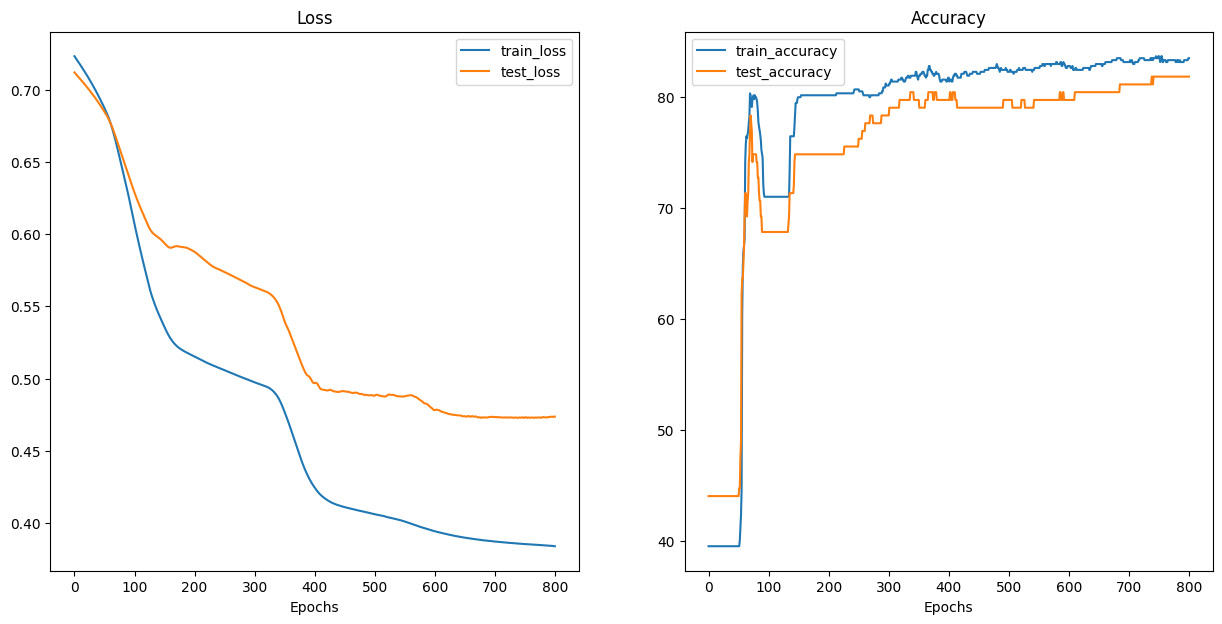

In [267]:
plt.figure(figsize=(15, 7))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs_list, torch.tensor(train_loss_list).detach(), label="train_loss")
plt.plot(epochs_list, test_loss_list, label="test_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_list, accuracy_list, label="train_accuracy")
plt.plot(epochs_list, test_accuracy_list, label="test_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()
    